<a href="https://colab.research.google.com/github/emilyj19/TS/blob/master/SQF_RNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch

In [0]:
import numpy as np 
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
root_path = 'gdrive/My Drive/FinancialTS/JPmarket_dataset.npz' 
data = np.load(root_path)
data.files

['train_ratios', 'test_ratios', 'train_volumes', 'test_volumes']

In [0]:
train_ratios = data['train_ratios']
test_ratios = data['test_ratios']
train_vols = data['train_volumes']
test_vols = data['test_volumes']

In [0]:
#need to change this to create windows for all stocks 
def split_data(n_days, data): #data for one stock in the form [days, bins]
  no_ts = data.shape[0]-n_days
  length_ts = n_days*data.shape[1]
  new_data = np.zeros((no_ts,length_ts))
  for j in range(no_ts):
    for i in range(n_days): 
      new_data[j,64*i:64*i + 64] = data[j+i,:]
  
  return new_data

In [0]:
#inputs: data of shape (num_series, num_days, num_bins), num_series = number of time series to use, len_series = length of series,  num_windows = number of series to create from each 
#output: data of shape (num_series, num_windows, len_series*bins)

def create_train_vols_data(data, num_series, len_series, num_windows): 
  total_num_series, num_days, num_bins = data.shape 
  days_series = int(len_series/num_bins)
  
  train_data = np.zeros((num_series, num_windows, len_series))
  
  for i in range(num_series): 
    series_i = data[i]
    norm_series_i = series_i/np.amax(series_i) #normalise series
    for j in range(num_windows):
      start_index = np.random.randint(0,num_days-days_series)
      train_data[i,j] = norm_series_i[start_index:start_index + days_series].flatten()
 
  return train_data

In [0]:
def make_test_data(train_data, test_data, n_days, stock_index):
  all_data = np.concatenate((train_data, test_data), axis = 1)
  
  one_data = all_data[stock_index]
  
  #now want to take only sets of n_days which contain the test data too 
  no_ts = test_data.shape[1]
  length_ts = n_days*one_data.shape[1]
  new_data = np.zeros((no_ts, length_ts))
  
  for j in range(no_ts): 
    for i in range(n_days): 
      new_data[j, 64*i:64*i + 64] = one_data[train_data.shape[1]+j-180+i+1,:]
      
  return new_data


testing_ratios = make_test_data(train_ratios, test_ratios, 180, 0)

In [0]:
def getbd_from_theta(theta): 
  gamma, beta, delta = theta
  L = len(beta)
  b = torch.zeros(L)
  for l in range(L): 
    if l == 0 : 
      b[l] = beta[l]
    else: 
      b[l] = beta[l]-beta[l-1]
  d = torch.zeros(L)
  for l in range(1,L): 
    d[l] = torch.sum(delta[:l])
    
  return b, d

In [0]:
def crps_loss(theta, z):
  
  gamma, beta, delta = theta
  L = len(beta)
  b, d = getbd_from_theta(theta)
  zeros = torch.zeros(L)
  
  lo = 0 
  for l in range(L-1, -1, -1): 
    val = sqf(theta, d[l])
    if val < z:
      lo = l
      break 
  
  a_tilde = (z-gamma + torch.sum(b[:lo+1]*d[:lo+1]))/torch.sum(b[:lo+1])
  max_ = torch.max(zeros+a_tilde, d)
  bracket = (1/3)*(1-torch.pow(d, 3)) - d - torch.pow(max_,2) + 2*max_*d
  loss = (2*a_tilde - 1)*z + (1-2*a_tilde)*gamma + torch.sum(b*bracket)
  
  return loss 

In [0]:
def sqf(theta, quantile): 
  
  gamma, beta, delta = theta
  L = len(beta)
  b,d = getbd_from_theta(theta)
  max_ = torch.max(quantile-d, torch.zeros(L))
  qf = gamma + torch.sum(b*max_)
  
  return qf

In [0]:
#covariate function 
#inputs - input_data of shape [number of time series, length of each time series], freq of data i.e. number of bins per day, and position of special bins as a vector
#returns - data and covariate vector of shape [number of series, length of series, number of special bins + 2] where covariate_vectors[:,:,0] is the input data, 
#covariate_vectors[:,:,1] is the scaled time of day and covariate_vectors[:,:,2:] is the one hot vector for the special bins
#therefore covariate_vectors[:,:,0] is the data and covariate_vectors[:,:,1:] is the actual covariate vector 

def new_create_covariate_data(input_data, freq, pos_of_special_bins): 
  num_series, len_series = input_data.shape
  days = int(len_series/freq)
  num_special_bins = len(pos_of_special_bins)
  covariate_vectors = np.zeros((num_series, len_series, num_special_bins+2))
  
  for n in range(num_series): 
    for d in range(days): 
      for t in range(freq): 
        x = np.zeros(num_special_bins + 1)
        #x[0] is the scaled time of day 
        x[0] = t/freq
        
        check = t in pos_of_special_bins
        
        if check == True: 
          index = pos_of_special_bins.index(t)
          x[index+1] = 1
          
        covariate_vectors[n, d*freq + t, 0] = input_data[n, d*freq + t]
        covariate_vectors[n, d*freq + t, 1:] = x
        
  return covariate_vectors
        
        

In [0]:
class Encoder(nn.Module): 
  
  def __init__(self, input_size, hidden_size, batch_size, output_size, num_layers):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.output_size = output_size
    self.num_layers = num_layers
    
    self.lstm = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.linear = nn.Linear(self.hidden_size, self.hidden_size)
    self.dense = nn.Linear(self.hidden_size, 1)
    self.softmax = nn.functional.softmax
    self.softplus = nn.functional.softplus
    
  def init_hidden(self): 
    return torch.zeros(self.num_layers, 1, self.hidden_size)
  
  def forward(self, data, hidden):
    lstm_out, hidden = self.lstm(data.view(1, 1, -1))
    fc_layer = self.linear(lstm_out.view(-1)) 
    delta = self.softmax(fc_layer)
    beta = self.softmax(fc_layer)
    gamma = self.dense(fc_layer)
    
    theta = (gamma, beta, delta)
    
    return theta, hidden 
  

In [0]:
learning_rate = 0.0005
#learning_rate_decay = 
num_epochs = 20
T = 5*64
num_paths = 50
pred_length = 64
num_lstm_layers = 2
hidden_units = 50
early_stop_patience = 20
number_series = 10
number_windows = 50
special_bins = [0,31,32,63]
batch_size = number_series

In [0]:
#inputs: data of shape (num_series, num_days, num_bins), num_series = number of time series to use, len_series = length of series,  num_windows = number of series to create from each 
#output: data of shape (num_series, num_windows, len_series*bins)

def create_train_vols_data(data, num_series, len_series, num_windows): 
  total_num_series, num_days, num_bins = data.shape 
  days_series = int(len_series/num_bins)
  
  train_data = np.zeros((num_series, num_windows, len_series))
  
  for i in range(num_series): 
    series_i = data[i]
    norm_series_i = series_i/np.amax(series_i) #normalise series
    for j in range(num_windows):
      start_index = np.random.randint(0,num_days-days_series)
      train_data[i,j] = norm_series_i[start_index:start_index + days_series].flatten()
 
  return train_data

In [0]:
#inputs: data of shape (num_series, num_days, num_bins), num_series = number of time series to use, len_series = length of series,  num_windows = number of series to create from each 
#output: data of shape (num_series, num_windows, len_series*bins)

def create_train_ratio_data(data, num_series, len_series, num_windows): 
  total_num_series, num_days, num_bins = data.shape 
  days_series = int(len_series/num_bins)
  
  train_data = np.zeros((num_series, num_windows, len_series))
  
  for i in range(num_series): 
    series_i = data[i]
    for j in range(num_windows):
      start_index = np.random.randint(0,num_days-days_series)
      train_data[i,j] = series_i[start_index:start_index + days_series].flatten()
 
  return train_data

In [0]:
training_vol = create_train_vols_data(train_vols[:,:-int(T/64)], number_series, T, number_windows)
covars_training_data = np.zeros((number_series, number_windows, T, len(special_bins)+2))

for i in range(number_series): 
  covars = new_create_covariate_data(training_vol[i], 64, special_bins)
  covars_training_data[i] = covars
  
  
covars_train_data = torch.FloatTensor(covars_training_data)

In [0]:
test_volume = train_vols[0:number_series].reshape((number_series,-1))

norm_test_vols = np.zeros(test_volume.shape)
for i in range(number_series): 
  norm_test_vols[i] = test_volume[i]/np.amax(train_vols[i])
  
new_test_data = norm_test_vols[:,-T:]

covars_test_data = new_create_covariate_data(new_test_data, 64, [0,31,32,63])

covars_test_data = torch.FloatTensor(covars_test_data)

In [92]:
encoder = Encoder(6, hidden_units, batch_size, 1, num_lstm_layers)
print(encoder)

Encoder(
  (lstm): LSTM(6, 50, num_layers=2)
  (linear): Linear(in_features=50, out_features=50, bias=True)
  (dense): Linear(in_features=50, out_features=1, bias=True)
)


In [94]:
### TRAINING the encoder###

loss_function = crps_loss
encoder_optimiser = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
train_loss = []
test_loss = []
early_stop_count = 0

for i in range(num_epochs): 
  encoder.zero_grad()
  encoder_hidden = encoder.init_hidden()
  
  batch_loss = 0
  
  batch_index = np.random.randint(0,number_windows)
  data_batch = covars_train_data[:,batch_index,:,:].contiguous()
  
  for j in range(batch_size):
    loss_t = 0 
    input_data = data_batch[j]
    
    for t in range(T-1): 
      theta, encoder_hidden = encoder(input_data[t:t+1], encoder_hidden)
      loss_t += loss_function(theta, input_data[t+1:t+2,0])
   
    batch_loss += loss_t
    
  loss_batch = batch_loss 
    
  encoder_optimiser.zero_grad()
  
  batch_loss.backward()

  encoder_optimiser.step()

  train_loss.append(batch_loss.item())
  
  with torch.no_grad(): 
    
    test_data_batch = covars_test_data
    test_batch_loss = 0
    
    for k in range(batch_size): 
      test_loss_t = 0 
      input_test_data = test_data_batch[k]

      for t in range(T-1): 
        theta, encoder_hidden = encoder(input_test_data[t:t+1], encoder_hidden)
        test_loss_t += loss_function(theta, input_test_data[t+1:t+2,0])
      
      test_batch_loss += loss_t
        
    test_loss.append(test_batch_loss.item())
    
  #early stopping
  if test_loss[i] >= test_loss[i-1]: 
    early_stop_count += 1
    if early_stop_count == early_stop_patience:
      break
  else: 
    early_stop_count = 0
    
  
  print("Epoch ", i, "train CRPS ", batch_loss.item(), 'test CRPS', test_loss[i])
  
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch  0 train CRPS  2686.013671875 test CRPS 2707.74169921875
Epoch  1 train CRPS  2190.446533203125 test CRPS 2072.896484375
Epoch  2 train CRPS  1903.6737060546875 test CRPS 1936.5625


KeyboardInterrupt: ignored

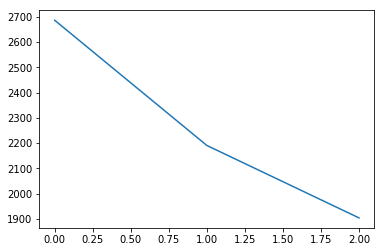

In [95]:
plt.plot(train_loss)

In [0]:
test_vol = test_vols[0:number_series].reshape((number_series,-1))

norm_test_vols = np.zeros(test_vol.shape)
for i in range(number_series): 
  norm_test_vols[i] = test_vol[i]/np.amax(test_vols[i])
  
new_test_data = norm_test_vols[:,:T+pred_length]

covars_test_data = new_create_covariate_data(new_test_data, 64, [0,31,32,63])

covars_test_data = torch.FloatTensor(covars_test_data)
input_test_data = covars_test_data

In [141]:
## PREDICTION ## 
decoder = encoder
paths = np.zeros((number_series, num_paths, T + pred_length))

with torch.no_grad(): 
  
  for  j in range(number_series): 
    input_data = input_test_data[j]
    
    for t in range(T): 
      theta, encoder_hidden = encoder(input_data[t], encoder_hidden)

    for n in range(num_paths): 

      decoder_input = input_data[T-1]
      decoder_hidden = encoder_hidden 
      sample_path = np.zeros(pred_length)

      for i in range(pred_length): 
        theta, decoder_hidden = decoder(decoder_input, decoder_hidden)
        alpha = torch.distributions.uniform.Uniform(0,1).rsample()
        z_hat = sqf(theta, alpha)
        sample_path[i] = z_hat.item()
        z_x = torch.zeros(len(special_bins)+2)
        z_x[0] = z_hat
        z_x[1] = i/64

        check = i in special_bins
        if check == True: 
          index = special_bins.index(i)
          z_x[index+2] = 1

        decoder_input = z_x

      paths[j,n,:T] = input_data[:,0]
      paths[j,n, T:] = sample_path


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: ignored

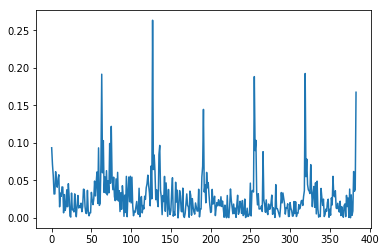

In [145]:
plt.plot(new_test_data[0])

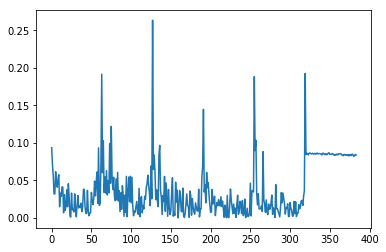

In [148]:
plt.plot(paths[0].mean(0))